In [42]:
import os
from pathlib import Path

import numpy as np
import librosa as lb
# import soundfile as sf
# import pyaudio
import sounddevice as sd

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn
import sklearn.decomposition

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

from models.VAE_1 import VAE_1
from utils.prepare_data import pad_or_trim

from utils.config import load_config

In [43]:
# def play_wave(wave, sr):
#     # initialize PyAudio
#     p = pyaudio.PyAudio()

#     # open a stream
#     stream = p.open(format=pyaudio.paFloat32,
#                     channels=1,
#                     rate=sr,
#                     output=True)

#     # play audio
#     stream.write(wave.tobytes())

#     # stop stream and terminate PyAudio
#     stream.stop_stream()
#     stream.close()
#     p.terminate()

In [44]:
def load_wave(path):
    sample, sr = lb.load(path)
    return sample, sr

def load_random_wave(sample_type, path_to_samples = r"C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\data\drums-one_shots"):
    # load random wave
    path = os.path.join(path_to_samples, sample_type, f'{sample_type}_samples')

    sample_name = np.random.choice(os.listdir(path))
    sample, sr = load_wave(os.path.join(path, sample_name))
    return sample, sr

def load_all_waves(sample_types: list, path_to_samples = r"C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\data\drums-one_shots", return_sample_groups = False):
    waves = []
    for sample_type in sample_types:
        path = os.path.join(path_to_samples, sample_type, f'{sample_type}_samples')
        for sample_name in os.listdir(path):
            sample, sr = load_wave(os.path.join(path, sample_name))
            if return_sample_groups:
                waves.append((sample, sr, sample_type))
            else:
                waves.append((sample, sr))
    return waves

def convert_to_mfcc(wave, sr):
    mfcc = lb.feature.mfcc(y=wave, sr=sr, **MFCC_KWARGS)
    return mfcc

def convert_to_wave(mfcc, sr):
    return lb.feature.inverse.mfcc_to_audio(mfcc=mfcc, sr=sr, **INVERSE_MFCC_KWARGS)

In [45]:
def sample_from_latent_space(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

def fuse_sampled_samples(samples, weights = None):
    if weights is None:
        weights = np.ones(len(samples)) / len(samples)
    return np.average(samples, axis=0, weights=weights).astype(np.float32)

In [46]:
import sys
sys.path.append(r'C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music')
# sys.path.append(r'/storage/praha1/home/buciak/bachelors_thesis/bachelor_thesis-Electronic_music')


model_dir_path = Path(r'C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\trained_models\model_kick,clap,hat,snare_latent-dims=32_noise=multiplicative')
# model_dir_path = Path(r'/storage/praha1/home/buciak/bachelors_thesis/test_results/test_no_noise')

model_name = os.path.basename(model_dir_path)
config = load_config(model_dir_path / f'{model_name}_config.json')

model = VAE_1(config.latent_dim)
model.load_state_dict(torch.load(model_dir_path / f'model_{model_name}.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [47]:
MFCC_KWARGS = config.mfcc_kwargs

INVERSE_MFCC_KWARGS = {
    'n_mels': MFCC_KWARGS['n_mels'],
    'dct_type': MFCC_KWARGS['dct_type'],
    'norm': MFCC_KWARGS['norm'],
    'lifter': MFCC_KWARGS['lifter'],
    'n_fft': MFCC_KWARGS['n_fft'],
    'hop_length': MFCC_KWARGS['hop_length'],
    'win_length': MFCC_KWARGS['win_length'],
    'window':  MFCC_KWARGS['window'],
    'center': MFCC_KWARGS['center'],
    'pad_mode': MFCC_KWARGS['pad_mode'],
    'power': MFCC_KWARGS['power'],


    'ref': 1.0,
    'n_iter': 32,
    'length': None,
    'dtype': np.float32
}


### sampling random souns from latent space

In [60]:
for i in range(20):
    wave, sr = load_random_wave('other')
    sd.play(wave, sr); sd.wait()

print('done')

for i in range(20):
    wave, sr = load_random_wave('other')
    sd.play(wave, sr); sd.wait()



done


In [48]:
wave, sr = load_random_wave('kick')

# x = pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length)
x = pad_or_trim(convert_to_mfcc(wave, sr), length=100)


reconstructed_x, mu, logvar = model(torch.tensor(x).view(1, 1, *x.shape))

reconstructed_wave = convert_to_wave(reconstructed_x.detach().numpy().reshape(-1, 100), sr)

sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))

logvar =  -1 * logvar


# sd.play(wave, sr); sd.wait()
# sd.play(reconstructed_wave, sr); sd.wait()
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, 100), sr), sr); sd.wait()

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


In [49]:
logvar

tensor([[11.1228, 10.2109, 10.3347,  9.4081,  9.5615,  9.1689,  7.5102, 11.3761,
         11.6415,  8.0632, 10.4279,  8.9129,  9.6416, 12.5471,  9.2413,  9.7702,
          9.8737, 10.4638,  8.8803, 11.0334,  9.2582, 10.2442, 11.1316,  8.8892,
         10.4019,  8.8350,  6.5339, 10.3245, 11.5882,  9.5513, 11.1061, 10.1526]],
       grad_fn=<MulBackward0>)

In [50]:
wave_1, sr_1 = load_random_wave('hat')
wave_2, sr_2 = load_random_wave('kick')

x_1 = pad_or_trim(convert_to_mfcc(wave_1, sr_1), length=100)
x_2 = pad_or_trim(convert_to_mfcc(wave_2, sr_2), length=100)

# x_1 = pad_or_trim(convert_to_mfcc(wave_1, sr_1), length=config.pad_or_trim_length)
# x_2 = pad_or_trim(convert_to_mfcc(wave_2, sr_2), length=config.pad_or_trim_length)

reconstructed_x_1, mu_1, logvar_1 = model(torch.tensor(x_1).view(1, 1, *x_1.shape))
reconstructed_x_2, mu_2, logvar_2 = model(torch.tensor(x_2).view(1, 1, *x_2.shape))

sampled_x_1 = model.decoder.forward(sample_from_latent_space(mu_1, logvar_1))
sampled_x_2 = model.decoder.forward(sample_from_latent_space(mu_2, logvar_2))

fusion = fuse_sampled_samples([sampled_x_1.detach().numpy().reshape(-1, 100), sampled_x_2.detach().numpy().reshape(-1, 100)], weights=[0.5, 0.5])

fusion_wave = convert_to_wave(model.encoder.forward(torch.tensor(fusion).view(1, 1, *fusion.shape))[0].detach().numpy(), sr_1)

sd.play(wave_1, sr); sd.wait()
sd.play(wave_2, sr); sd.wait()
sd.play(convert_to_wave(fusion, sr), sr); sd.wait()

### Histogram of euclidean distances between center and waves

In [51]:
sample_groups = config.sample_group.split(',') if config.sample_group != 'all' else ['kick', 'clap', 'hat', 'snare', 'tom', 'cymbal', 'crash', 'ride']

# mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length) for wave, sr in load_all_waves(sample_groups)]
mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=100) for wave, sr in load_all_waves(sample_groups)]

means_logvars = [model.encoder(torch.tensor(x).view(1, 1, *x.shape)) for x in mfccs]

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=510
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=415
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=277
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=306
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=490
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal

(array([  4.,   6.,   9.,  17.,  21.,  15.,  31.,  47.,  56., 127., 153.,
        218., 263., 273., 303., 326., 342., 361., 372., 363., 395., 366.,
        461., 490., 425., 450., 412., 359., 347., 344., 290., 307., 265.,
        266., 268., 243., 221., 207., 146., 143., 113.,  89.,  95.,  65.,
         56.,  56.,  50.,  51.,  37.,  34.,  36.,  28.,  30.,  29.,  27.,
         22.,  27.,  16.,  20.,  22.,  12.,  22.,  14.,  20.,  22.,  21.,
         17.,  16.,  15.,  16.,  13.,   4.,   5.,  10.,  10.,   6.,   8.,
          4.,  10.,   6.,   8.,   2.,   5.,   3.,   3.,   1.,   7.,   0.,
          0.,   3.,   3.,   1.,   0.,   1.,   1.,   1.,   0.,   2.,   0.,
          1.]),
 array([ 24.60983089,  25.7135622 ,  26.8172935 ,  27.92102481,
         29.02475612,  30.12848743,  31.23221874,  32.33595005,
         33.43968135,  34.54341266,  35.64714397,  36.75087528,
         37.85460659,  38.9583379 ,  40.06206921,  41.16580051,
         42.26953182,  43.37326313,  44.47699444,  45.58072575

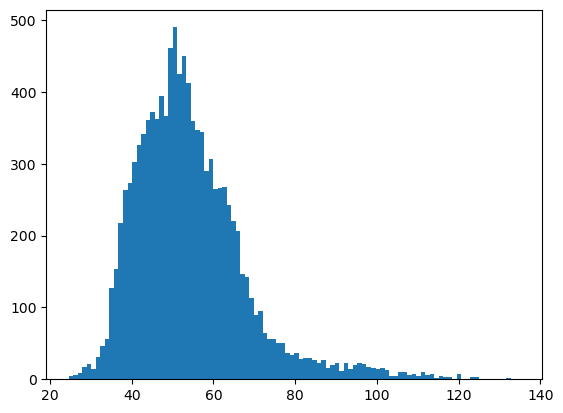

In [52]:
center = np.zeros(config.latent_dim)

euler_dists = [np.linalg.norm(mean.detach().numpy() - center) for mean, _ in means_logvars]

plt.hist(euler_dists, bins=100)

In [53]:
sample_groups = config.sample_group.split(',') if config.sample_group != 'all' else ['kick', 'clap', 'hat', 'snare', 'tom', 'cymbal', 'crash', 'ride']

# mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length) for wave, sr in load_all_waves(sample_groups)]
mfccs_sample_groups = [(pad_or_trim(convert_to_mfcc(wave, sr), length=100), sample_group) for wave, sr, sample_group in load_all_waves(sample_groups, return_sample_groups=True)]

means_and_sample_groups = [(model.encoder(torch.tensor(x).view(1, 1, *x.shape))[0].detach().numpy().squeeze() ,sample_group) for x, sample_group in mfccs_sample_groups]

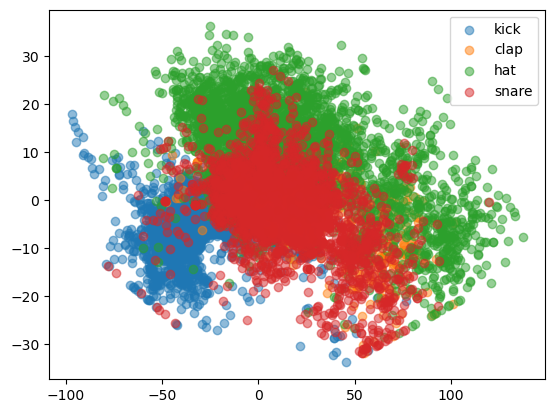

In [54]:
pca = sklearn.decomposition.PCA(n_components=2)

means = [mean for mean, _ in means_and_sample_groups]

pca.fit(means)

for sample_group in sample_groups:
    plt.scatter(*zip(*pca.transform([mean for mean, group in means_and_sample_groups if group == sample_group])), label=sample_group, alpha=0.5)

plt.legend()
plt.show()

(4045, 3)
(1103, 3)
(2700, 3)
(3060, 3)


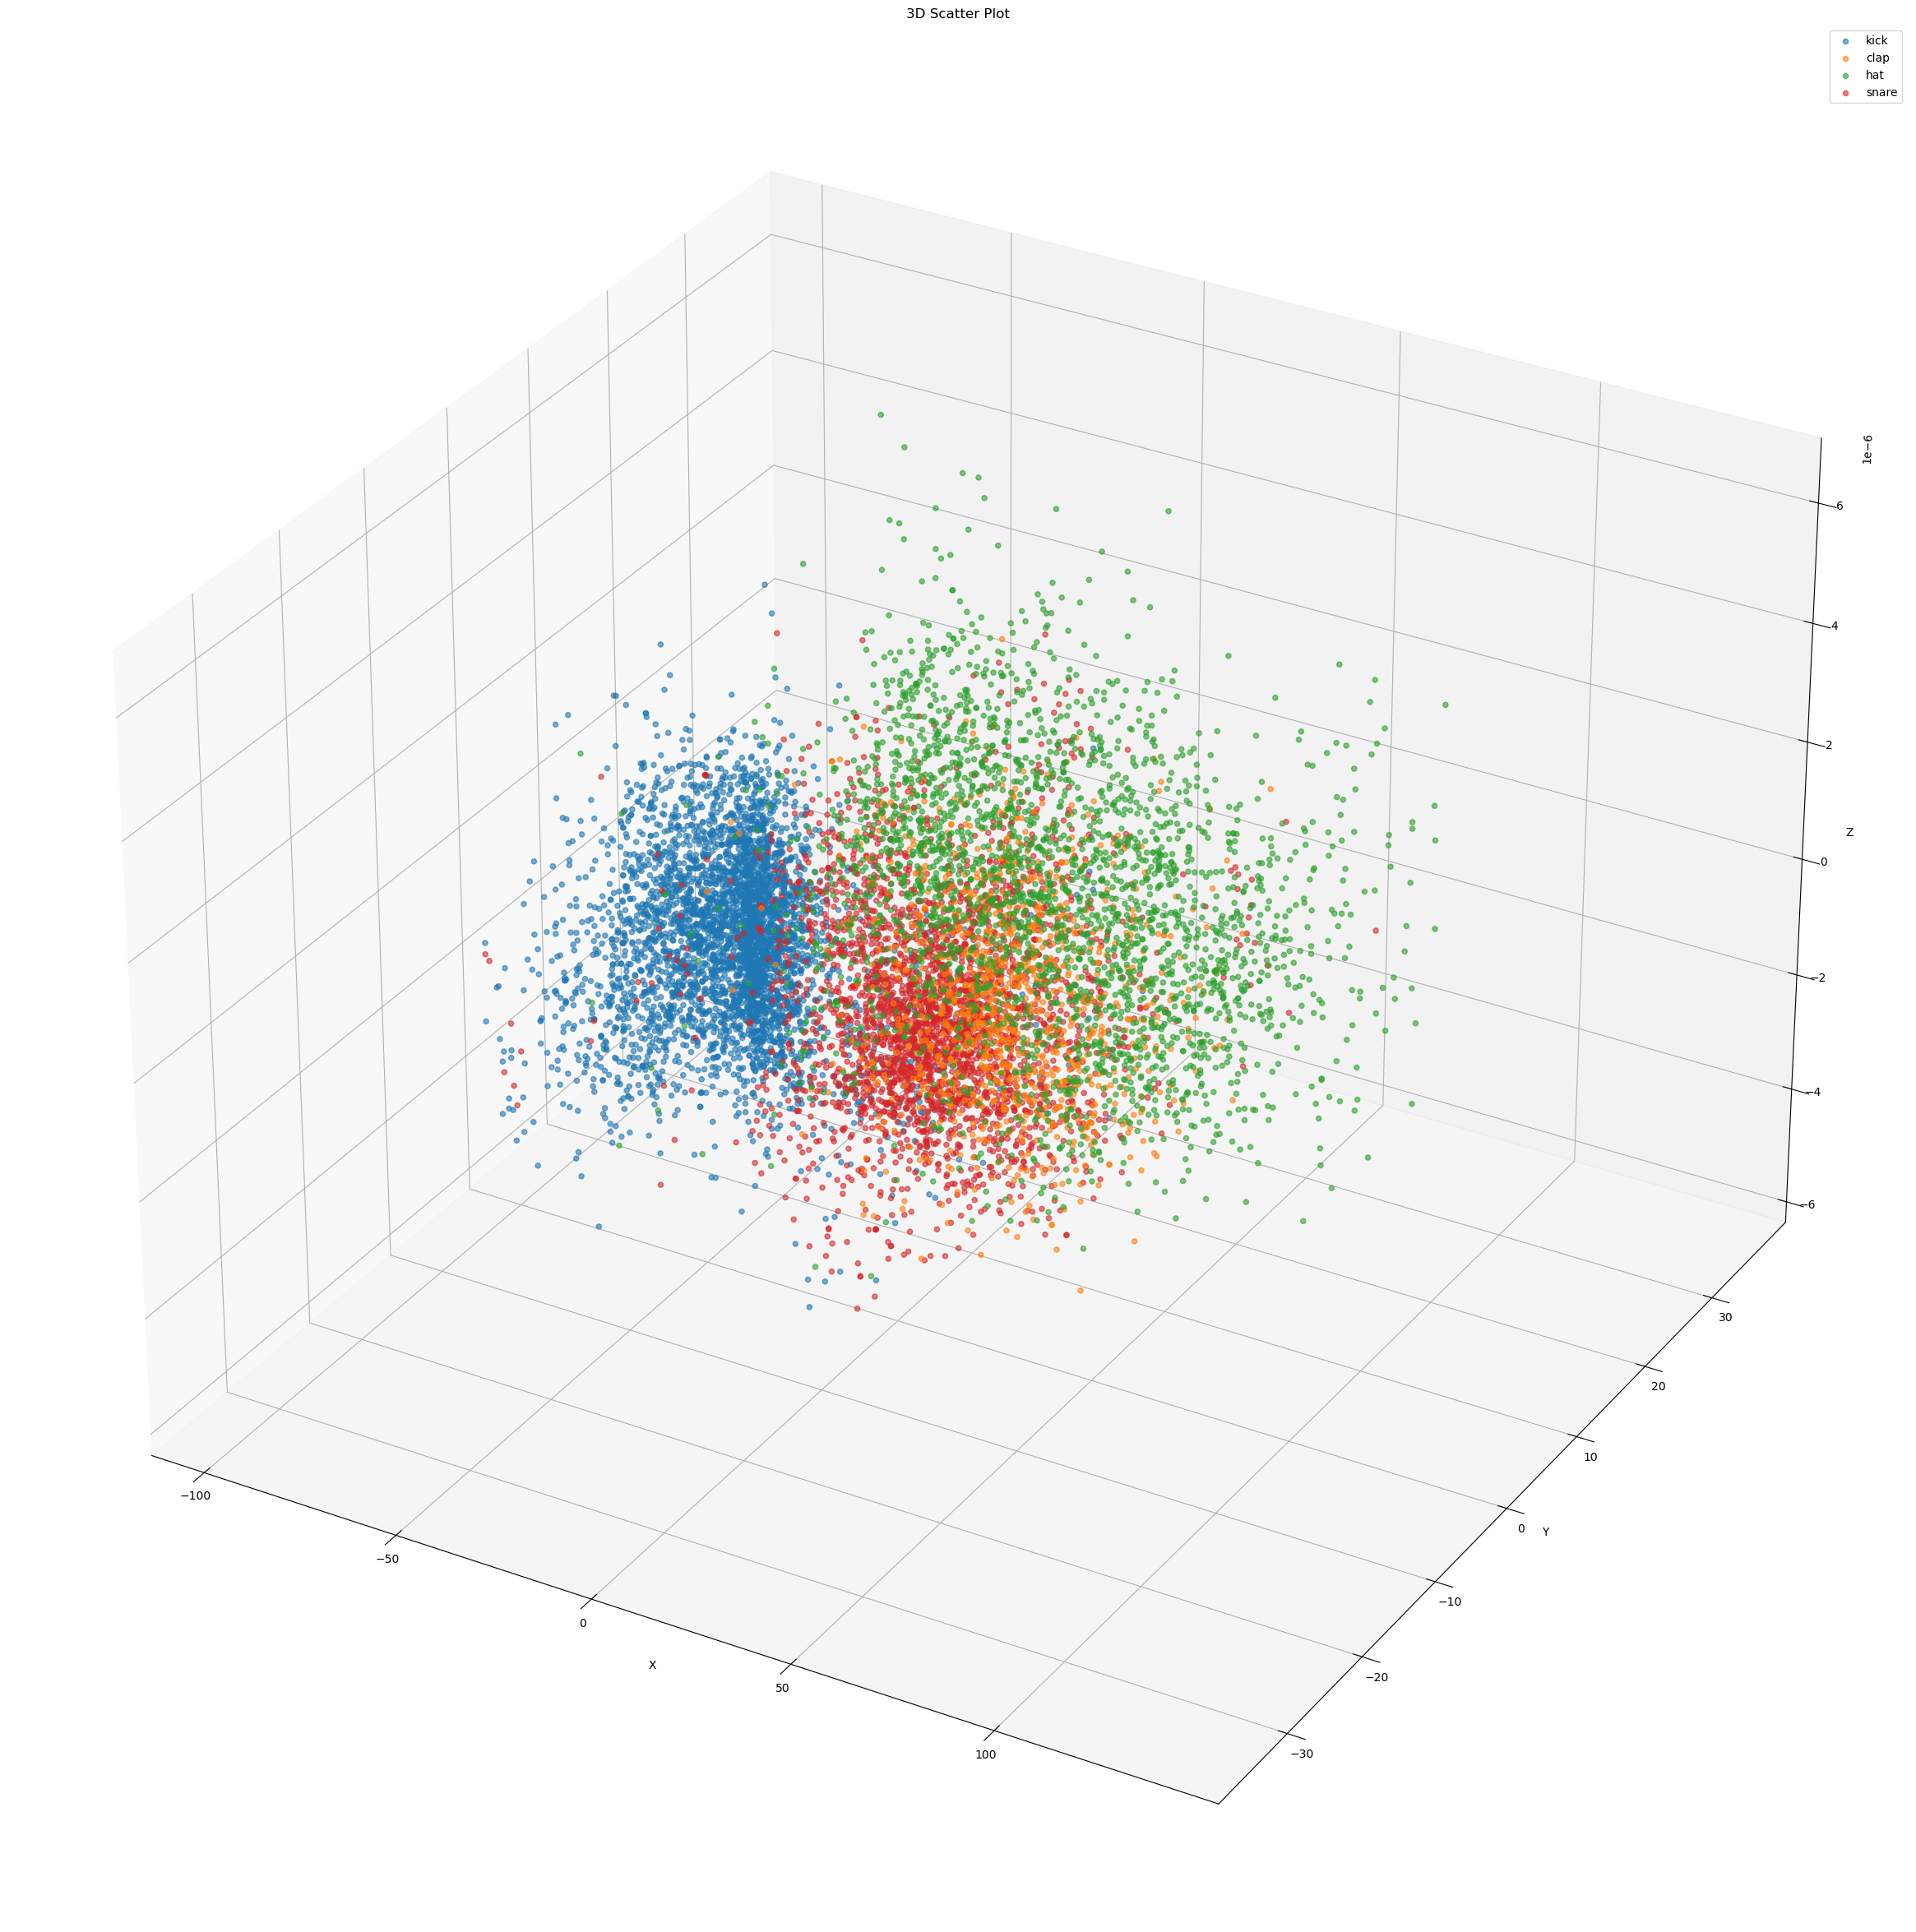

In [57]:
pca = sklearn.decomposition.PCA(n_components=3)

means = [mean for mean, _ in means_and_sample_groups]

pca.fit(means)


fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot') 


for sample_group in sample_groups:
    transformed = pca.transform([mean for mean, group in means_and_sample_groups if group == sample_group])

    print(transformed.shape)

    x = transformed[:, 0]
    y = transformed[:, 1]
    z = transformed[:, 2]

    ax.scatter(x, y, z, label=sample_group, alpha=0.6)


plt.legend()
plt.show()

### posun zvuku v latent space o alpha nasobok pca vektoru

In [28]:
pca = sklearn.decomposition.PCA()

means = [mean.detach().numpy().squeeze() for mean, _ in means_logvars]

pca.fit(means)

comp = pca.components_
comp.shape

plt.plot(pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>

In [15]:
vector_1 = (comp[0] / np.linalg.norm(comp[0])).astype(np.float32)   
vector_2 = (comp[1] / np.linalg.norm(comp[1])).astype(np.float32)
vector_3 = (comp[2] / np.linalg.norm(comp[2])).astype(np.float32)
vector_4 = (comp[3] / np.linalg.norm(comp[3])).astype(np.float32)

In [16]:
vector = vector_4

wave, sr = load_random_wave('snare')
x = pad_or_trim(convert_to_mfcc(wave, sr), length=100)

mean, logvar = model.encoder.forward(torch.tensor(x).view(1, 1, *x.shape))

mean = mean.detach().numpy().squeeze()

sd.play(wave, sr); sd.wait()

for alpha in [0,0.1,0.5,1,5,10,50,100, 200, 500]:
    sd.play(convert_to_wave(model.decoder.forward(torch.tensor(mean + alpha * vector).view(1, 1, config.latent_dim)).detach().numpy().reshape(-1, 100), sr), sr)
    print(str(alpha) + '          ', end='\r')
    sd.wait()

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


### Corelation Metrics

Intra Cluster Correlation: 44.256027
Inter Cluster Correlation: 44.255974
